In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [74]:
from lets_plot import *
LetsPlot.setup_html()

In [1]:
# import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow.experimental.numpy as tnp
import csv
from dataclasses import dataclass
from pathlib import Path
from itertools import product   
from collections import OrderedDict
from rich import inspect
from functools import partial
from tqdm.notebook import tqdm

# Read a pandas DataFrame

from nbeats_keras.model import NBeatsNet
# from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch

# warnings.filterwarnings(action='ignore', message='Setting attributes')

In [125]:
info_df=pd.read_csv(Path('.')/f'data/Dataset/M4-info.csv')

In [126]:
@dataclass()
class M4Meta:
    ids=info_df.M4id.values
    groups=info_df.SP.values
    seasonal_patterns = ['Yearly', 'Quarterly', 'Monthly', 'Weekly', 'Daily', 'Hourly']
    horizons = [6, 8, 18, 13, 14, 48]
    frequencies = [1, 4, 12, 1, 1, 24]
    horizons_map = {
        'Yearly': 6,
        'Quarterly': 8,
        'Monthly': 18,
        'Weekly': 13,
        'Daily': 14,
        'Hourly': 48
    }
    frequency_map = {
        'Yearly': 1,
        'Quarterly': 4,
        'Monthly': 12,
        'Weekly': 1,
        'Daily': 1,
        'Hourly': 24
    }
    history_size = {
    'Yearly': 1.5,
    'Quarterly': 1.5,
    'Monthly': 1.5,
    'Weekly': 10,
    'Daily': 10,
    'Hourly': 10
}
    iterations = {
    'Yearly': 15000,
    'Quarterly': 15000,
    'Monthly': 15000,
    'Weekly': 5000,
    'Daily': 5000,
    'Hourly': 5000
}
    initial_learning_rate = {
    'Yearly': 1e-4,
    'Quarterly': 1e-4,
    'Monthly': 1e-4,
    'Weekly': 1e-4,
    'Daily': 1e-4,
    'Hourly': 5e-4
}
    batch_size = {
    'Yearly': 4096*16,
    'Quarterly': 4096*16,
    'Monthly': 4096*64,
    'Weekly': 4096*4,
    'Daily': 4096*16,
    'Hourly': 4096*16
}

Epoch 1/20
12/12 [==============================] - 1s 5ms/step - loss: 0.0770 - root_mean_squared_error: 0.2776 - mean_absolute_error: 0.1826
Epoch 2/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920 - mean_absolute_error: 0.0723
Epoch 3/20
12/12 [==============================] - 0s 5ms/step - loss: 0.0029 - root_mean_squared_error: 0.0537 - mean_absolute_error: 0.0420
Epoch 4/20
12/12 [==============================] - 0s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - mean_absolute_error: 0.0348
Epoch 5/20
12/12 [==============================] - 0s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - mean_absolute_error: 0.0299
Epoch 6/20
12/12 [==============================] - 0s 5ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - mean_absolute_error: 0.0285
Epoch 7/20
12/12 [==============================] - 0s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - mean_absolute_error: 0.0297

In [111]:
def timeseries_sampler(timeseries,insample_size,outsample_size,window_sampling_limit,batch_size):
    insample = np.zeros((batch_size, insample_size),dtype=np.float32)
    outsample = np.zeros((batch_size, outsample_size),dtype=np.float32)
    sampled_ts_indices = np.random.randint(len(timeseries), size=batch_size)
    # sampled_ts_indices = fixed_sampled_ts_indices
    for i, sampled_index in enumerate(sampled_ts_indices):
        sampled_timeseries = timeseries[sampled_index]
        cut_point = np.random.randint(low=max(1, len(sampled_timeseries) - window_sampling_limit),
                                      high=len(sampled_timeseries),
                                      size=1)[0]
        insample_window = sampled_timeseries[max(0, cut_point - insample_size):cut_point]
        insample[i, -len(insample_window):] = insample_window
        outsample_window = sampled_timeseries[
                           cut_point:min(len(sampled_timeseries), cut_point + outsample_size)]
        outsample[i, :len(outsample_window)] = outsample_window
    yield insample,outsample

def last_insample_window(timeseries, insample_size):
    """
    The last window of insample size of all timeseries.
    This function does not support batching and does not reshuffle timeseries.
    :return: Last insample window of all timeseries. Shape "timeseries, insample size"
    """
    insample = np.zeros((len(timeseries), insample_size))
    for i, ts in enumerate(timeseries):
        ts_last_window = ts[-insample_size:]
        insample[i, -len(ts):] = ts_last_window
    return insample

def plot_from_history(history):
    data={}
    val_data={}
    for key in history.history.keys():
        if key.startswith('val'):
            val_data[key]=history.history[key]
            val_data[f'_{key}']=[key]*len(val_data[key])
        else:
            data[key]=history.history[key]
            data[f'_{key}']=[key]*len(data[key])
    data['epoch']=np.array(history.epoch)+1
    epochs=len(data['epoch'])
    val_epochs=len(val_data['val_loss'])
    val_freq=epochs // val_epochs
    val_data['epoch']=np.arange(val_freq,epochs,val_freq)
    plot=(
        ggplot(data,aes(x='epoch'))+
        geom_line(aes(y='loss',color='_loss'))+
        geom_line(aes(y='val_loss',color='_val_loss'),data=val_data)+
        labs(color="Legend text")+
        ylim(0,0.3)
    )

    return plot


# losses

In [39]:

def mape_loss(y_true,y_pred):
    """
    MAPE loss as defined in: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    :param forecast: Forecast values. Shape: batch, time
    :param target: Target values. Shape: batch, time
    :param mask: 0/1 mask. Shape: batch, time
    :return: Loss value
    """
    # mask=tf.cast(~tnp.isnan(y_true),tf.float32)
    condition=tf.cast(y_true,tf.bool)
    weights=tf.where(condition,1./y_true,.0)
    # weights = 1/y_true*mask
    return 100*tnp.nanmean(tf.abs((y_pred - y_true) * weights))

def smape_loss(y_true,y_pred):
    """
    sMAPE loss as defined in "Appendix A" of
    http://www.forecastingprinciples.com/files/pdf/Makridakia-The%20M3%20Competition.pdf
    :param forecast: Forecast values. Shape: batch, time
    :param target: Target values. Shape: batch, time
    :param mask: 0/1 mask. Shape: batch, time
    :return: Loss value
    """
    # mask=tf.where(y_true,1.,0.)
    mask=tf.cast(y_true,tf.bool)
    mask=tf.cast(mask,tf.float32)
    sym_sum= tf.abs(y_true)+tf.abs(y_pred) 
    condition=tf.cast(sym_sum,tf.bool)
    weights=tf.where(condition,1./( sym_sum + 1e-8),0.0)
    return 200 * tnp.nanmean(tf.abs(y_pred - y_true)*weights * mask)

# def mase_loss(insample: t.Tensor, freq: int,
#               forecast: t.Tensor, target: t.Tensor, mask: t.Tensor) -> t.float:
#     """
#     MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf
#     :param insample: Insample values. Shape: batch, time_i
#     :param freq: Frequency value
#     :param forecast: Forecast values. Shape: batch, time_o
#     :param target: Target values. Shape: batch, time_o
#     :param mask: 0/1 mask. Shape: batch, time_o
#     :return: Loss value
#     """
#     masep = t.mean(t.abs(insample[:, freq:] - insample[:, :-freq]), dim=1)
#     masked_masep_inv = divide_no_nan(mask, masep[:, None])
#     return t.mean(t.abs(target - forecast) * masked_masep_inv)

In [40]:

LOSSES={
    'mape':mape_loss,
    'smape':smape_loss
}


def group_values(values: np.ndarray, groups: np.ndarray, group_name: str) -> np.ndarray:
    """
    Filter values array by group indices and clean it from NaNs.
    :param values: Values to filter.
    :param groups: Timeseries groups.
    :param group_name: Group name to filter by.
    :return: Filtered and cleaned timeseries.
    """
    return np.array([v[~np.isnan(v)] for v in values[groups == group_name]])
def summarize_groups(scores):
    """
    Re-group scores respecting M4 rules.
    :param scores: Scores per group.
    :return: Grouped scores.
    """
    scores_summary = OrderedDict()

    def group_count(group_name):
        return len(np.where(M4Meta.groups == group_name)[0])

    weighted_score = {}
    for g in ['Yearly', 'Quarterly', 'Monthly']:
        weighted_score[g] = scores[g] * group_count(g)
        scores_summary[g] = scores[g]

    others_score = 0
    others_count = 0
    for g in ['Weekly', 'Daily', 'Hourly']:
        others_score += scores[g] * group_count(g)
        others_count += group_count(g)
    weighted_score['Others'] = others_score
    scores_summary['Others'] = others_score / others_count

    average = np.sum(list(weighted_score.values())) / len(M4Meta.groups)
    scores_summary['Average'] = average

    return scores_summary

def evaluate_result(forecast,targets):
    forecast = np.array([v[~np.isnan(v)] for v in forecast],dtype='object')
    results={
    freq:smape_loss(
        group_values(targets,M4Meta.groups,freq),
        group_values(forecast,M4Meta.groups,freq)
    ).numpy() for freq in M4Meta.seasonal_patterns
    }
    return pd.DataFrame(summarize_groups(results),index=['smape'])

array([[1101.5, 1111.4, 1114.1, ..., 1115.7, 1119.4, 1118.6],
       [2918.8, 2933.1, 2920.2, ..., 2996.8, 3035.7, 3023.7],
       [1000.3,  997.5,  994.7, ...,  952.7,  949.9,  947.1],
       ...,
       [1709. , 1750. , 1763. , ..., 1783. , 1783. , 1794. ],
       [1405.8, 1411.6, 1404.1, ..., 1475.3, 1459.8, 1442.3],
       [9478.4, 9539.5, 9446.4, ..., 9141.4, 8993.8, 9022.7]])

<AxesSubplot:>

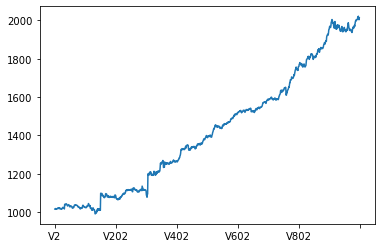

In [35]:

def read_data(freq):
    pwd=Path('.')
    filename_train = pwd/Path(f'data/Dataset/Train/{freq}-train.csv')
    df=pd.read_csv(filename_train)
    tss=df.drop('V1',axis=1).values.copy(order='C').astype(np.float32)
    def dropna(x):
        return x[~np.isnan(x)]

    timeseries=[dropna(ts) for ts in tss]
    filename_test = pwd/Path(f'data/Dataset/Test/{freq}-test.csv')
    df=pd.read_csv(filename_test)
    targets=df.drop('V1',axis=1).values.copy(order='C').astype(np.float32)
    return timeseries,targets

def generate_dataset(timeseries,targets,insample_size,outsample_size,window_sampling_limit,batch_size):
    # train_ds=tf.data.Dataset.from_generator(
    #     partial(timeseries_sampler,timeseries),
    #     args=(tf.constant(insample_size),tf.constant(outsample_size),tf.constant(window_sampling_limit),tf.constant(batch_size)),
    #     output_signature=(
    #         tf.TensorSpec(shape=(batch_size,insample_size)),
    #         tf.TensorSpec(shape=(batch_size,outsample_size)),
    #     )
    # )

    insamples=[]
    outsamples=[]
    for sampled_timeseries in timeseries:
        # windowsed_tss=np.lib.stride_tricks.sliding_window_view(ts,insample_size+outsample_size)
        # cut_point=int(min(window_sampling_limit,len(ts)))
        # insample=windowsed_tss[cut_point:,:insample_size]
        # outsample=windowsed_tss[cut_point:,-outsample_size:]
        # insamples.append(insample)
        # outsamples.append(outsample)
        gen_size=min(window_sampling_limit,len(sampled_timeseries)-1)
        insample = np.zeros((gen_size,insample_size),dtype=np.float32)
        outsample = np.zeros((gen_size,outsample_size),dtype=np.float32)
        for idx,cut_point in enumerate(np.arange(
                        start=max(1, len(sampled_timeseries) - window_sampling_limit),
                        stop=len(sampled_timeseries),
                        dtype=int)):
            insample_window = sampled_timeseries[max(0, cut_point - insample_size):cut_point]
            insample[idx,-len(insample_window):] = insample_window
            outsample_window = sampled_timeseries[
                               cut_point:min(len(sampled_timeseries), cut_point + outsample_size)]
            outsample[idx,:len(outsample_window)] = outsample_window
        insamples.append(insample)
        outsamples.append(outsample)

    x_train=np.concatenate(insamples)
    y_train=np.concatenate(outsamples)
    train_ds=tfio.experimental.IODataset.from_numpy(( x_train,y_train )).shuffle(window_sampling_limit).batch(batch_size)

    x_test=last_insample_window(timeseries,insample_size)
    y_test=targets
    test_ds=tfio.experimental.IODataset.from_numpy(( x_test,y_test )).batch(batch_size)

    return train_ds,test_ds


def create_model(insample_size,outsample_size):
    net = NBeatsNet(
        # stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
        stack_types=(NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK),
        nb_blocks_per_stack=3,
        forecast_length=outsample_size,
        backcast_length=insample_size,
        hidden_layer_units=512,
        thetas_dim=(4,4),
        share_weights_in_stack=True,
        nb_harmonics=1
        )
    return net

def trainer(train_ds,test_ds,loss,model,epoch,val_freq=100,verbose=0,initial_learning_rate=0.001):
    net=model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=epoch // 3,
        decay_rate=0.5,
        staircase=True)

    es_callback=tf.keras.callbacks.EarlyStopping(
        monitor='smape_loss', patience=20,
        restore_best_weights=True,
        verbose=1
    )
    net.compile(loss=LOSSES[loss], 
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=lr_schedule,
            clipnorm=1.0
        ),
        metrics=[LOSSES['smape']]
    )
    # iterrations=5000
    history=net.fit(
        x=train_ds.cache(),
        epochs=epoch,
        validation_data=test_ds,
        validation_freq=val_freq,
        verbose=verbose,
        callbacks=[es_callback]
    )

    return net, history

In [31]:
def create_forecast(lookback,loss,repeat,freq):
    logger.error(f"==================={lookback}-{loss}-{repeat}-{freq}================")
    epoch=M4Meta.iterations[freq] // 10
    horizon=M4Meta.horizons_map[freq]
    history_size_in_horizons=M4Meta.history_size[freq]
    initial_learning_rate = M4Meta.initial_learning_rate[freq]
    batch_size=M4Meta.batch_size[freq]
    window_sampling_limit=int(history_size_in_horizons*horizon)
    insample_size=lookback*horizon
    outsample_size=horizon
    timeseries,targets=read_data(freq)

    train_ds,test_ds=generate_dataset(timeseries,targets,insample_size,outsample_size,window_sampling_limit,batch_size)
    x_test=last_insample_window(timeseries,insample_size)
    y_test=targets
    net=create_model(insample_size, outsample_size)
    net,history=trainer(train_ds,test_ds,loss,net,epoch,verbose=2,initial_learning_rate=initial_learning_rate,val_freq=50)

    y_pred=net.predict(x_test).reshape(-1,outsample_size)
    results=LOSSES[loss](y_test, y_pred)
    logger.error(f"\t loss in {freq} dataset result in {results}")
    # if results>30:
    #     logger.error(f"encouter large loss,retrain")
    #     create_forecast(lookback, loss, repeat, freq)
    return y_pred

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49
0,H1,619.0,565.0,532.0,495.0,481.0,467.0,473.0,488.0,501.0,...,812.0,836.0,838.0,829.0,807.0,785.0,756.0,719.0,703.0,659.0
1,H2,2771.0,2396.0,2189.0,1984.0,1872.0,1843.0,1828.0,1872.0,1952.0,...,3018.0,3206.0,3356.0,3499.0,3550.0,3558.0,3488.0,3224.0,3054.0,2918.0
2,H3,1455.0,1376.0,1235.0,1101.0,1003.0,943.0,905.0,886.0,910.0,...,1457.0,1529.0,1627.0,1701.0,1754.0,1791.0,1819.0,1791.0,1758.0,1679.0
3,H4,5327.0,5051.0,4683.0,4319.0,4049.0,3847.0,3712.0,3639.0,3652.0,...,5337.0,5675.0,5926.0,6159.0,6313.0,6072.0,5612.0,5220.0,4895.0,4793.0
4,H5,3823.0,3501.0,3039.0,2613.0,2312.0,2079.0,1938.0,1839.0,1821.0,...,2345.0,2529.0,2737.0,3028.0,3292.0,3453.0,3574.0,3522.0,3338.0,3041.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,H410,48.0,43.0,37.0,31.0,32.0,40.0,116.0,164.0,135.0,...,163.0,187.0,180.0,175.0,171.0,170.0,131.0,124.0,167.0,126.0
410,H411,38.0,20.0,21.0,21.0,33.0,70.0,162.0,263.0,217.0,...,145.0,170.0,156.0,122.0,116.0,86.0,77.0,63.0,62.0,74.0
411,H412,27.0,19.0,14.0,17.0,15.0,23.0,47.0,92.0,94.0,...,80.0,87.0,106.0,79.0,81.0,78.0,54.0,53.0,72.0,40.0
412,H413,34.0,26.0,19.0,14.0,14.0,17.0,24.0,23.0,19.0,...,92.0,103.0,108.0,101.0,86.0,99.0,88.0,47.0,41.0,34.0


<AxesSubplot:>

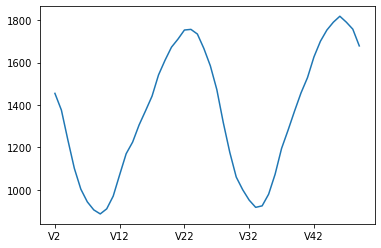

In [32]:
fre1="Yearly"
logger.error(f"==================={lookback}-{loss}-{repeat}-{freq}================")
epoch=M4Meta.iterations[freq] // 10
horizon=M4Meta.horizons_map[freq]
history_size_in_horizons=M4Meta.history_size[freq]
initial_learning_rate = M4Meta.initial_learning_rate[freq]
batch_size=M4Meta.batch_size[freq]
window_sampling_limit=int(history_size_in_horizons*horizon)
insample_size=lookback*horizon
outsample_size=horizon
timeseries,targets=read_data(freq)

train_ds,test_ds=generate_dataset(timeseries,targets,insample_size,outsample_size,window_sampling_limit,batch_size)

In [57]:
next(train_ds.as_numpy_iterator())[0].shape

array([[0, 2, 3, 0],
       [1, 1, 0, 3]])

In [ ]:

x_test=last_insample_window(timeseries,insample_size)
y_test=targets
net=create_model(insample_size, outsample_size)
net,history=trainer(train_ds,test_ds,loss,net,epoch,verbose=2,initial_learning_rate=initial_learning_rate,val_freq=50)

y_pred=net.predict(x_test).reshape(-1,outsample_size)
results=LOSSES[loss](y_test, y_pred)
logger.error(f"\t loss in {freq} dataset result in {results}")

In [ ]:

# losses:MASE,MAPE,SMAPE
# loockbacks:2,3,4,5,6,7
# repeat 10

def experimental(lookback,loss,repeat):
    forecasts=[]
    for freq in tqdm(M4Meta.seasonal_patterns):
    # for freq in ['Daily', 'Hourly']:
        forecasts.extend(create_forecast(lookback, loss, repeat, freq))

    evaluate_path=Path('./nbeats_result')
    forecasts_df = pd.DataFrame(forecasts, columns=[f'V{i + 1}' for i in range(np.max(M4Meta.horizons))])
    forecasts_df.index = M4Meta.ids
    forecasts_df.index.name = 'id'
    forecasts_df.to_csv(evaluate_path/f'{lookback}_{loss}_{repeat}.csv')

In [ ]:
%%capture tfout
experimental(7, 'smape', 0)

In [ ]:
lookback=[2,3,4,5,6,7]
loss=['smape','mape']
# repeat=list(range(10))
repeat=[0]
for lookback,loss,repeat in tqdm(product(lookback,loss,repeat)):
    experimental(lookback,loss,repeat)

In [ ]:
targets=[]
for freq in tqdm(M4Meta.seasonal_patterns):
    filename_test = Path('.')/(f'data/Dataset/Test/{freq}-test.csv')
    df=pd.read_csv(filename_test)
    target=df.drop('V1',axis=1).values.copy(order='C').astype(np.float32)
    targets.extend(target)
    # for freq in ['Daily', 'Hourly']:
targets=np.array(targets,dtype='object')

In [ ]:
evaluate_path=Path('./nbeats_result')
result_files=list(evaluate_path.glob("**/*.csv"))
ensemble_forecast=(
pd.concat([pd.read_csv(file)
                      for file in
                      tqdm(result_files)], sort=False) 
  .set_index('id')
  .groupby(level='id', sort=False)
  .median() 
)
forecast=pd.read_csv(result_files[0]).set_index('id').values.astype(np.float32)

In [ ]:
evaluate_result(forecast,targets)

In [ ]:
dfs=[]
for freq in ['Daily', 'Hourly']:
    timeseries,targets=read_data(freq)
    df=pd.DataFrame(timeseries)
    dfs.append(df)

pd.concat(dfs).mean(axis=1).describe()

In [ ]:

# net.save_weights(model_path)
# _net = NBeatsNet(
#     # stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
#     stack_types=(NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK),
#     nb_blocks_per_stack=3,
#     forecast_length=outsample_size,
#     backcast_length=insample_size,
#     hidden_layer_units=512,
#     thetas_dim=(4,4),
#     share_weights_in_stack=True,
#     nb_harmonics=1
#     )

# _net.load_weights(model_path)
# weights=_net.get_weights()

# _net.set_weights(weights)

# np.testing.assert_almost_equal(
# _net.predict(x_test),
# net.predict(x_test),
# )

In [ ]:
from loguru import logger
logger.add("file_{time}.log",level="ERROR")

In [3]:
p_degree=3
pv=tf.reshape(tf.range(p_degree + 1, dtype='float32'), shape=(-1, 1))

In [14]:
pv.shape

TensorShape([4, 1])

In [5]:
tf.range(10.0)**pv

<tf.Tensor: shape=(4, 10), dtype=float32, numpy=
array([[  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
       [  0.,   1.,   4.,   9.,  16.,  25.,  36.,  49.,  64.,  81.],
       [  0.,   1.,   8.,  27.,  64., 125., 216., 343., 512., 729.]],
      dtype=float32)>